# 뗑컨 몸무게 예측 경진대회

## 패키지 import 및 데이터 전처리

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/train.csv')

In [3]:
df.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g)
0,0,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,50.0,15.3,220,MALE,8.30515,-25.19017,5550
1,1,Chinstrap penguin (Pygoscelis antarctica),Dream,No,49.5,19.0,200,MALE,9.63074,-24.34684,3800
2,2,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,45.1,14.4,210,FEMALE,8.51951,-27.01854,4400
3,3,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,44.5,14.7,214,FEMALE,8.20106,-26.16524,4850
4,4,Gentoo penguin (Pygoscelis papua),Biscoe,No,49.6,16.0,225,MALE,8.38324,-26.84272,5700


In [4]:
df.rename(columns = {'Clutch Completion':'Full_Clutch', 'Culmen Length (mm)':'Culmen_Length', 
                     'Culmen Depth (mm)':'Culmen_Depth', 'Flipper Length (mm)':'Flipper_Length',
                     'Delta 15 N (o/oo)':'DeltaN', 'Delta 13 C (o/oo)':'DeltaC', 'Body Mass (g)':'Body_Mass'}, inplace = True) ## 열 이름 변경

In [5]:
df.drop('id', axis = 1, inplace = True) ## id는 필요없으니 제거 

In [6]:
df.isnull().sum()

Species           0
Island            0
Full_Clutch       0
Culmen_Length     0
Culmen_Depth      0
Flipper_Length    0
Sex               3
DeltaN            3
DeltaC            3
Body_Mass         0
dtype: int64

`-` Sex, Delta 15 N, Delta 13 C 컬럼에 결측치가 3개씩 존재한다

In [7]:
## 결측치가 있는 row들을 확인
df[df.isna().sum(axis = 1) > 0]

,Species,Island,Full_Clutch,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC,Body_Mass
6,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,42.0,20.2,190,NaN,9.13362,-25.09368,4250
8,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,34.1,18.1,193,NaN,NaN,NaN,3475
18,Adelie Penguin (Pygoscelis adeliae),Dream,No,39.8,19.1,184,MALE,NaN,NaN,4650
70,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,46.2,14.4,214,NaN,8.24253,-26.81540,4650
109,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,36.6,17.8,185,FEMALE,NaN,NaN,3700


`-` 방사성 동위원소 행의 결측치에는 각각의 중앙값을 넣어주자

In [8]:
df['DeltaN'].fillna(df['DeltaN'].median(), inplace = True)
df['DeltaC'].fillna(df['DeltaC'].median(), inplace = True)

`-` EDA를 보면 알겠지만 Species별로 몸무게가 다르다

`-` 또한 수컷과 암컷간의 차이도 꽤 있다

`-` drop해도 되지만 3개의 데이터가 유실되는 것이기에 Species와 Body_Mass를 통해 결측치에 값을 채워넣자

In [9]:
df.groupby(['Species', 'Sex']).\
agg({'Body_Mass':np.mean}).reset_index()

,Species,Sex,Body_Mass
0,Adelie Penguin (Pygoscelis adeliae),FEMALE,3448.611111
1,Adelie Penguin (Pygoscelis adeliae),MALE,4097.619048
2,Chinstrap penguin (Pygoscelis antarctica),FEMALE,3550.000000
3,Chinstrap penguin (Pygoscelis antarctica),MALE,4018.181818
4,Gentoo penguin (Pygoscelis papua),FEMALE,4707.608696
5,Gentoo penguin (Pygoscelis papua),MALE,5445.833333


`-` 6번 펭귄의 성별은 수컷, 8번은 암컷, 70번은 암컷으로 하자

In [10]:
df.loc[[6,8,70], 'Sex']= ['MALE','FEMALE', 'FEMALE']

`-` 이상으로 결측치 처리는 끝났다

In [11]:
df.isnull().sum().sum() ## 이제 결측치는 없다

0

## 모델링을 해보자

`-` 뗑컨 데이터셋의 크기는 114로 그리 많지 않다

`-` 그렇기에 overfitting이 일어날 가능성이 꽤 있으며 변수간의 상관관계도 강하다

`-` 이를 해결하기 위해 cost fuction에 규제항을 추가한 릿지, 라쏘, 엘라스틱 넷을 써보자

### preprocessing

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
dt = df.copy()

In [14]:
dt = dt.iloc[:, :-1]      ## target 제외한 데이터프레임
target = df['Body_Mass']  ## target

`-` 라벨인코딩을 해주자

In [15]:
from sklearn.preprocessing import LabelEncoder

In [16]:
for col in dt.columns:
    if dt.dtypes[col] == 'O':
        encoder = LabelEncoder()    
        labels = encoder.fit_transform(dt[col])
        dt[col] = list(labels) 

In [17]:
dt.head()

,Species,Island,Full_Clutch,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC
0,2,0,1,50.0,15.3,220,1,8.30515,-25.19017
1,1,1,0,49.5,19.0,200,1,9.63074,-24.34684
2,2,0,1,45.1,14.4,210,0,8.51951,-27.01854
3,2,0,1,44.5,14.7,214,0,8.20106,-26.16524
4,2,0,0,49.6,16.0,225,1,8.38324,-26.84272


`-` 범주형 변수마다 라벨인코딩이 잘 되었다

In [18]:
x_train, x_valid, y_train, y_valid = train_test_split(dt, target, test_size = 0.2, shuffle = True,
                                                      stratify = dt['Species'], random_state = 21)
## 종의 비율이 train, valid 비슷하도록 세팅함

## 릿지 회귀(Ridge Regressor)

In [19]:
def RMSE(real, predict):
    return np.sqrt(np.mean(np.square(real - predict)))

In [20]:
from sklearn.linear_model import Ridge

In [161]:
ridge = Ridge(alpha = 10) ## alpha = 10인 릿지 회귀 모형 생성
ridge.fit(x_train, y_train) ## 모델 학습
y_predict = ridge.predict(x_valid) ## 모델 예측
rmse = RMSE(y_predict, y_valid) ## 예측값과 실제값을 통해 RMSE를 구함
print('이 방정식의 평균 에러는 {:.2f}입니다'.format(rmse))

이 방정식의 평균 에러는 291.16입니다


`-` 여러개의 $\alpha$에 대해 rmse를 계산해보자

In [176]:
alphas = [0.01, 0.1, 1, 10, 50, 100]

## alpha 값들에 대해 rmse를 구함
for alpha in alphas:
    ridge = Ridge(alpha = alpha)
    ridge.fit(x_train, y_train) ## 모델 학습
    y_predict = ridge.predict(x_valid) ## 모델 예측
    rmse = RMSE(y_predict, y_valid) ## 예측값과 실제값을 통해 RMSE를 구함
    print('𝛼가 {}일 때 이 방정식의 평균 에러는 {:.2f}입니다'.format(alpha, rmse))

𝛼가 0.01일 때 이 방정식의 평균 에러는 268.04입니다
𝛼가 0.1일 때 이 방정식의 평균 에러는 268.04입니다
𝛼가 1일 때 이 방정식의 평균 에러는 269.10입니다
𝛼가 10일 때 이 방정식의 평균 에러는 291.16입니다
𝛼가 50일 때 이 방정식의 평균 에러는 313.83입니다
𝛼가 100일 때 이 방정식의 평균 에러는 319.01입니다


`-` $\alpha$가 작아질수록 평균 에러가 작아진다

### $\alpha$에 따른 회귀 계수 시각화

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

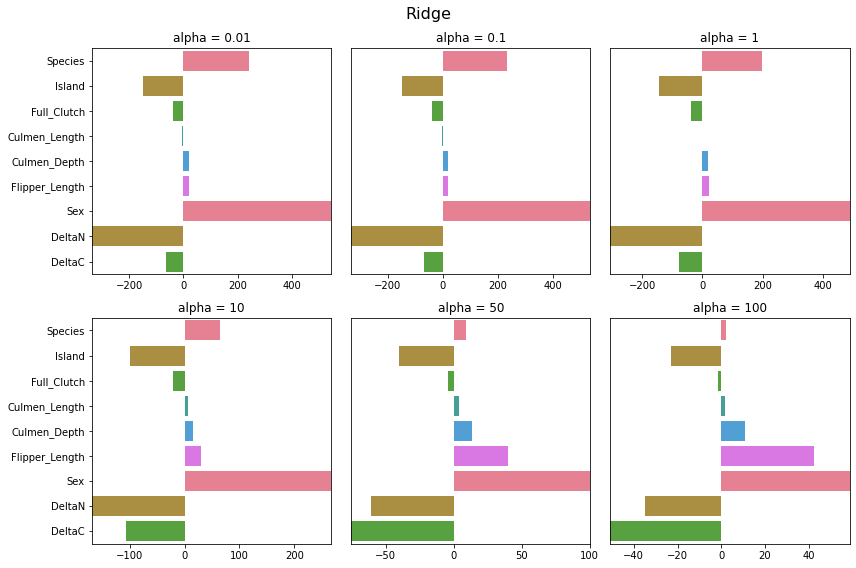

In [214]:
fig, axs = plt.subplots(2, 3, figsize = (12, 8))
colors = sns.color_palette('husl', 6)
coeff_df = pd.DataFrame()
alphas = [0.01, 0.1, 1, 10, 50, 100]

for i, alpha in enumerate(alphas):
    ridge = Ridge(alpha = alpha)
    ridge.fit(x_train, y_train)

    coeff = pd.Series(data = ridge.coef_, index = x_train.columns)
    colname = 'alpha = ' + str(alpha)
    coeff_df[colname] = coeff

    axs[i//3][i%3].set_title(colname)
    axs[i//3][i%3].set_xlim(min(coeff),max(coeff))
    sns.barplot(x = coeff.values, y = coeff.index, palette = colors, ax = axs[i//3][i%3])
    if i != 0 and i != 3:
        axs[i//3][i%3].set(yticklabels = [])   
        axs[i//3][i%3].set(ylabel = None)
        axs[i//3][i%3].tick_params(left = False)  

fig.suptitle('Ridge', fontsize = 16)
fig.tight_layout()

`-` $\alpha$가 커짐에 따라 회귀계수가 작아진다

## 라쏘 회귀(Lasso Regressor)

In [21]:
from sklearn.linear_model import Lasso

`-` $\alpha$가 커짐에 따라 계수가 $0$되는 항이 많아진다

In [175]:
alphas = [0.01, 0.1, 1, 10, 50, 100]

## alpha 값들에 대해 rmse를 구함
for alpha in alphas:
    lasso = Lasso(alpha = alpha)
    lasso.fit(x_train, y_train) ## 모델 학습
    y_predict = lasso.predict(x_valid) ## 모델 예측
    rmse = RMSE(y_predict, y_valid) ## 예측값과 실제값을 통해 RMSE를 구함
    print('𝛼가 {}일 때 이 방정식의 평균 에러는 {:.2f}입니다'.format(alpha, rmse))

𝛼가 0.01일 때 이 방정식의 평균 에러는 268.00입니다
𝛼가 0.1일 때 이 방정식의 평균 에러는 267.67입니다
𝛼가 1일 때 이 방정식의 평균 에러는 264.49입니다
𝛼가 10일 때 이 방정식의 평균 에러는 255.46입니다
𝛼가 50일 때 이 방정식의 평균 에러는 311.57입니다
𝛼가 100일 때 이 방정식의 평균 에러는 327.98입니다


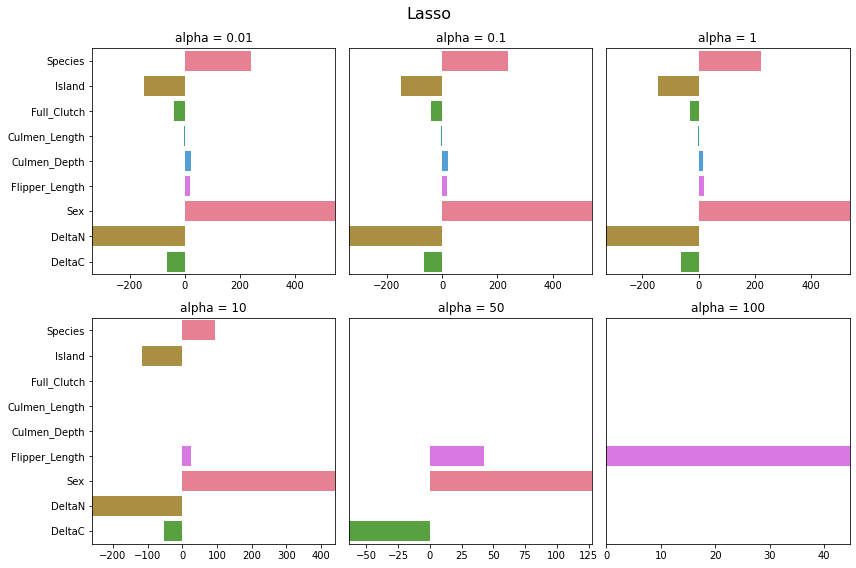

In [215]:
fig, axs = plt.subplots(2, 3, figsize = (12, 8))
colors = sns.color_palette('husl', 6)
coeff_df = pd.DataFrame()
alphas = [0.01, 0.1, 1, 10, 50, 100]

for i, alpha in enumerate(alphas):
    lasso = Lasso(alpha = alpha)
    lasso.fit(x_train, y_train)

    coeff = pd.Series(data = lasso.coef_, index = x_train.columns)
    colname = 'alpha = ' + str(alpha)
    coeff_df[colname] = coeff

    axs[i//3][i%3].set_title(colname)
    axs[i//3][i%3].set_xlim(min(coeff),max(coeff))
    sns.barplot(x = coeff.values, y = coeff.index, palette = colors, ax = axs[i//3][i%3])
    if i != 0 and i != 3:
        axs[i//3][i%3].set(yticklabels = [])   
        axs[i//3][i%3].set(ylabel = None)
        axs[i//3][i%3].tick_params(left = False)  

fig.suptitle('Lasso', fontsize = 16)
fig.tight_layout()

## 엘라스틱 넷(Elastic Net)

`-` 라쏘 회귀에서의 규제항(L1)과 릿지 회귀에서의 규제항(L2)을 비율에 따라 혼합한 규제항을 사용 

In [187]:
from sklearn.linear_model import ElasticNet

In [198]:
alphas = [0.01, 0.1, 1, 10]
L1_ratios = [0.05, 0.2, 0.5, 0.8, 0.95]
## alpha 값들에 대해 rmse를 구함
for alpha in alphas:
    for L1_ratio in L1_ratios:
        elastic_net = ElasticNet(alpha = alpha, l1_ratio = L1_ratio)
        elastic_net.fit(x_train, y_train) ## 모델 학습
        y_predict = elastic_net.predict(x_valid) ## 모델 예측
        rmse = RMSE(y_predict, y_valid) ## 예측값과 실제값을 통해 RMSE를 구함
        print('𝛼가 {}이고 L1_raio가 {}일 때 이 방정식의 평균 에러는 {:.2f}입니다'.format(alpha, L1_ratio, rmse))
    print('\n', end = '')

𝛼가 0.01이고 L1_raio가 0.05일 때 이 방정식의 평균 에러는 268.85입니다
𝛼가 0.01이고 L1_raio가 0.2일 때 이 방정식의 평균 에러는 268.62입니다
𝛼가 0.01이고 L1_raio가 0.5일 때 이 방정식의 평균 에러는 268.25입니다
𝛼가 0.01이고 L1_raio가 0.8일 때 이 방정식의 평균 에러는 268.04입니다
𝛼가 0.01이고 L1_raio가 0.95일 때 이 방정식의 평균 에러는 268.00입니다

𝛼가 0.1이고 L1_raio가 0.05일 때 이 방정식의 평균 에러는 288.65입니다
𝛼가 0.1이고 L1_raio가 0.2일 때 이 방정식의 평균 에러는 285.76입니다
𝛼가 0.1이고 L1_raio가 0.5일 때 이 방정식의 평균 에러는 278.81입니다
𝛼가 0.1이고 L1_raio가 0.8일 때 이 방정식의 평균 에러는 270.86입니다
𝛼가 0.1이고 L1_raio가 0.95일 때 이 방정식의 평균 에러는 267.96입니다

𝛼가 1이고 L1_raio가 0.05일 때 이 방정식의 평균 에러는 318.07입니다
𝛼가 1이고 L1_raio가 0.2일 때 이 방정식의 평균 에러는 316.89입니다
𝛼가 1이고 L1_raio가 0.5일 때 이 방정식의 평균 에러는 313.02입니다
𝛼가 1이고 L1_raio가 0.8일 때 이 방정식의 평균 에러는 301.27입니다
𝛼가 1이고 L1_raio가 0.95일 때 이 방정식의 평균 에러는 277.80입니다

𝛼가 10이고 L1_raio가 0.05일 때 이 방정식의 평균 에러는 332.59입니다
𝛼가 10이고 L1_raio가 0.2일 때 이 방정식의 평균 에러는 331.16입니다
𝛼가 10이고 L1_raio가 0.5일 때 이 방정식의 평균 에러는 328.05입니다
𝛼가 10이고 L1_raio가 0.8일 때 이 방정식의 평균 에러는 323.53입니다
𝛼가 10이고 L1_raio가 0.95일 때 이 방정식의 평균 에러는 314.74입니다



`-` 뗑컨 데이터에 대해서는 일라스틱 넷에서 L1_ratio가 높을수록 RMSE가 작다

`-` 릿지, 라쏘와 엘라스틱 넷의 차이를 느끼고자 L1_ratio는 0.5로 하자

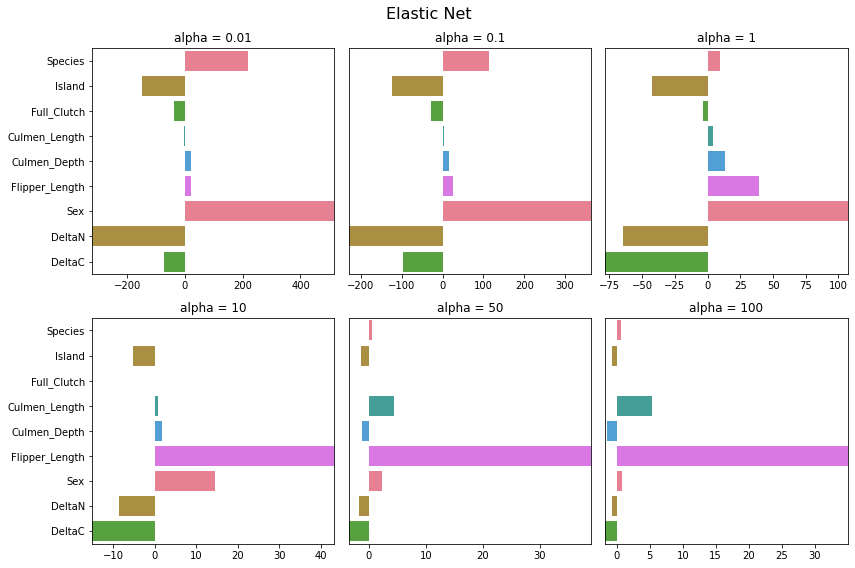

In [216]:
fig, axs = plt.subplots(2, 3, figsize = (12, 8))
colors = sns.color_palette('husl', 6)
coeff_df = pd.DataFrame()
alphas = [0.01, 0.1, 1, 10, 50, 100]

for i, alpha in enumerate(alphas):
    elastic_net = ElasticNet(alpha = alpha)
    elastic_net.fit(x_train, y_train)

    coeff = pd.Series(data = elastic_net.coef_, index = x_train.columns)
    colname = 'alpha = ' + str(alpha)
    coeff_df[colname] = coeff

    axs[i//3][i%3].set_title(colname)
    axs[i//3][i%3].set_xlim(min(coeff),max(coeff))
    sns.barplot(x = coeff.values, y = coeff.index, palette = colors, ax = axs[i//3][i%3])
    if i != 0 and i != 3:
        axs[i//3][i%3].set(yticklabels = [])   
        axs[i//3][i%3].set(ylabel = None)
        axs[i//3][i%3].tick_params(left = False)  

fig.suptitle('Elastic Net', fontsize = 16)
fig.tight_layout()

`-` 회귀계수들이 작아지고 계수가 $0$인 변수도 존재한다

## 라쏘 회귀 + 교호작용 + 표준화

`-` EDA를 통해 봤을 때는 특별히 교호작용을 추가할 필요는 느끼지 못했는데 라쏘 회귀를 통해 확인하자

### 교호작용항 추가

In [22]:
numeric_features = df.columns[(df.dtypes == np.int64) | (df.dtypes == float)][:-1]
categorical_features = df.columns[df.dtypes == 'O']

In [23]:
def poly(df):
    df2 = df.copy()
    for categorical_feature in categorical_features:
        for numeric_feature in numeric_features:
            df2[categorical_feature + '_' + numeric_feature] = df2[categorical_feature] * df2[numeric_feature]
        
    return df2

In [24]:
x_poly_train = poly(x_train)
x_poly_valid = poly(x_valid)

In [25]:
x_train.shape, x_poly_train.shape  ## 교호작용항을 추가하니 피쳐의 수가 9에서 29로 늘어났다

((91, 9), (91, 29))

### 표준화

`-` 위의 교호작용항을 추가한 train, valid 셋을 표준화해주자

In [26]:
from sklearn.preprocessing import StandardScaler

## 스케일러 생성
standard_scaler = StandardScaler()

## 트레인집합 정규화
x_poly_train_scaled = standard_scaler.fit_transform(x_poly_train)
x_poly_train_scaled_df = pd.DataFrame(data = x_poly_train_scaled, columns = x_poly_train.columns)

## 테스트집합 정규화
x_poly_valid_scaled = standard_scaler.transform(x_poly_valid) ## x_train에서 학습한 정규화방식을 그대로 x_valid에 적용
x_poly_valid_scaled_df = pd.DataFrame(data = x_poly_valid_scaled, columns = x_poly_valid.columns)

### 라쏘 회귀

`-` $\alpha$에 따른 rmse를 구해보자

In [288]:
alphas = [0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
for alpha in alphas:
    lasso = Lasso(alpha = alpha, max_iter = 20000, random_state = 21)
    lasso.fit(x_poly_train_scaled_df, y_train)
    y_predict = lasso.predict(x_poly_valid_scaled_df) ## 모델 예측
    rmse = RMSE(y_predict, y_valid) ## 예측값과 실제값을 통해 RMSE를 구함
    print('𝛼가 {}일 때 이 방정식의 평균 에러는 {:.2f}입니다'.format(alpha, rmse))

𝛼가 0.3일 때 이 방정식의 평균 에러는 224.92입니다
𝛼가 0.5일 때 이 방정식의 평균 에러는 237.58입니다
𝛼가 0.6일 때 이 방정식의 평균 에러는 243.05입니다
𝛼가 0.7일 때 이 방정식의 평균 에러는 246.01입니다
𝛼가 0.8일 때 이 방정식의 평균 에러는 248.03입니다
𝛼가 0.9일 때 이 방정식의 평균 에러는 250.25입니다
𝛼가 0.99일 때 이 방정식의 평균 에러는 252.43입니다


`-` $\alpha$가 작다는것은 규제를 적게 한다는 의미 ---> 오버피팅 가능성 높아짐

`-` 피쳐수도 29개라 $\alpha$를 크게하는것이 일반화에 좋을 것 임

### 릿지 회귀

`-` 라쏘 회귀만 하기엔 아쉬우니 릿지 회귀도 해보자

In [291]:
alphas = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
for alpha in alphas:
    ridge = Ridge(alpha = alpha, max_iter = 20000, random_state = 21)
    ridge.fit(x_poly_train_scaled_df, y_train)
    y_predict = ridge.predict(x_poly_valid_scaled_df) ## 모델 예측
    rmse = RMSE(y_predict, y_valid) ## 예측값과 실제값을 통해 RMSE를 구함
    print('𝛼가 {}일 때 이 방정식의 평균 에러는 {:.2f}입니다'.format(alpha, rmse))

𝛼가 0.1일 때 이 방정식의 평균 에러는 238.11입니다
𝛼가 0.3일 때 이 방정식의 평균 에러는 246.98입니다
𝛼가 0.5일 때 이 방정식의 평균 에러는 251.14입니다
𝛼가 0.7일 때 이 방정식의 평균 에러는 253.86입니다
𝛼가 0.9일 때 이 방정식의 평균 에러는 255.86입니다
𝛼가 0.99일 때 이 방정식의 평균 에러는 256.60입니다


`-` 라쏘 회귀보다 평균 에러가 더 높게 나온다

### 엘라스틱 넷

In [297]:
alphas = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
for alpha in alphas:
    elastic_net = ElasticNet(alpha = alpha, l1_ratio = 0.5, max_iter = 20000, random_state = 21)
    elastic_net.fit(x_poly_train_scaled_df, y_train)
    y_predict = elastic_net.predict(x_poly_valid_scaled_df) ## 모델 예측
    rmse = RMSE(y_predict, y_valid) ## 예측값과 실제값을 통해 RMSE를 구함
    print('𝛼가 {}일 때 이 방정식의 평균 에러는 {:.2f}입니다'.format(alpha, rmse))

𝛼가 0.1일 때 이 방정식의 평균 에러는 266.97입니다
𝛼가 0.3일 때 이 방정식의 평균 에러는 271.54입니다
𝛼가 0.5일 때 이 방정식의 평균 에러는 273.53입니다
𝛼가 0.7일 때 이 방정식의 평균 에러는 275.26입니다
𝛼가 0.9일 때 이 방정식의 평균 에러는 277.16입니다
𝛼가 0.99일 때 이 방정식의 평균 에러는 278.10입니다


`-` 성능은 라쏘 > 릿지 > 엘라스틱 넷

### test 예측

`-` 성능이 가장 좋게 나온 라쏘 회귀 모형을 통해 test 데이터를 예측하자

`-` $\alpha = 0.7$로 하자

In [27]:
test = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/test.csv')
test.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,0,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,52.0,20.7,210.0,MALE,9.43146,-24.68440
1,1,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,55.9,17.0,228.0,MALE,8.31180,-26.35425
2,2,Adelie Penguin (Pygoscelis adeliae),Dream,Yes,38.9,18.8,190.0,FEMALE,8.36936,-26.11199
3,3,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,45.2,16.6,191.0,FEMALE,9.62357,-24.78984
4,4,Adelie Penguin (Pygoscelis adeliae),Biscoe,No,37.9,18.6,172.0,FEMALE,8.38404,-25.19837


In [28]:
test.isnull().sum()

id                     0
Species                0
Island                 0
Clutch Completion      0
Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Sex                    6
Delta 15 N (o/oo)      9
Delta 13 C (o/oo)      8
dtype: int64

In [29]:
test['Delta 15 N (o/oo)'].fillna(dt['DeltaN'].mean(), inplace = True)
test['Delta 13 C (o/oo)'].fillna(dt['DeltaC'].mean(), inplace = True)

In [30]:
test.rename(columns = {'Clutch Completion':'Full_Clutch', 'Culmen Length (mm)':'Culmen_Length', 
                     'Culmen Depth (mm)':'Culmen_Depth', 'Flipper Length (mm)':'Flipper_Length',
                     'Delta 15 N (o/oo)':'DeltaN', 'Delta 13 C (o/oo)':'DeltaC', 'Body Mass (g)':'Body_Mass'}, inplace = True) ## 열 이름 변경

In [31]:
test.loc[[46,81,98,152,205,209], 'Sex'] = ['FEMALE'] * 6

In [32]:
test.drop('id', axis = 1, inplace = True)

`-` test 셋도 범주형변수에 대해 라벨 인코딩을 해주자

In [33]:
test2 = test.copy()
for col in test2.columns:
    if test2.dtypes[col] == 'O':
        encoder = LabelEncoder()
        encoder.fit(test2[col])
        labels = encoder.transform(test2[col])
        test2[col] = list(labels) 

In [34]:
test2.head()

,Species,Island,Full_Clutch,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC
0,1,1,1,52.0,20.7,210.0,1,9.43146,-24.68440
1,2,0,1,55.9,17.0,228.0,1,8.31180,-26.35425
2,0,1,1,38.9,18.8,190.0,0,8.36936,-26.11199
3,1,1,1,45.2,16.6,191.0,0,9.62357,-24.78984
4,0,0,0,37.9,18.6,172.0,0,8.38404,-25.19837


`-` 라벨 인코딩이 잘 되었다

`-` 교호작용항 추가

In [35]:
test_poly = poly(test2)

In [36]:
## 테스트집합 정규화
test_poly_scaled = standard_scaler.transform(test_poly) ## x_train에서 학습한 정규화방식을 그대로 test에 적용
test_poly_scaled_df = pd.DataFrame(data = test_poly_scaled, columns = test_poly.columns)

In [322]:
test_poly_scaled_df.iloc[:6, 10:15]

,Species_Culmen_Depth,Species_Flipper_Length,Species_DeltaN,Species_DeltaC,Island_Culmen_Length
0,0.300297,-0.079342,0.060404,0.113680,0.914425
1,1.293330,1.195717,1.044630,-1.094197,-0.914580
2,-1.245249,-1.167808,-1.230268,1.177612,0.453657
3,-0.005825,-0.177823,0.086694,0.109136,0.675247
4,-1.245249,-1.167808,-1.230268,1.177612,-0.914580
5,0.233100,-0.146724,0.002238,0.116513,0.939046


`-` 이제 예측을 하자

In [47]:
lasso = Lasso(alpha = 0.7, max_iter = 20000, random_state = 21)
lasso.fit(x_poly_train_scaled_df, y_train)
predict_test = lasso.predict(test_poly_scaled_df) ## 모델 예측

# 예측 결과를 확인
predict_test[:6]

array([4284.72911825, 5602.49239502, 3641.82755582, 3474.95393474,
       3783.73909796, 4118.42263249])

`-` 피쳐네임과 회귀계수 값을 함께 봐보자

In [49]:
list(zip(test_poly_scaled_df,lasso.coef_))

[('Species', 0.0),
 ('Island', 0.0),
 ('Full_Clutch', 2.6412589035640606),
 ('Culmen_Length', 0.18669090503011523),
 ('Culmen_Depth', 330.71346933691206),
 ('Flipper_Length', 224.90152805339403),
 ('Sex', 425.3027731377754),
 ('DeltaN', -291.5003671117297),
 ('DeltaC', -97.91974641966688),
 ('Species_Culmen_Length', 665.4099883913643),
 ('Species_Culmen_Depth', -532.4193132071174),
 ('Species_Flipper_Length', 633.4141236085387),
 ('Species_DeltaN', -376.81803286381546),
 ('Species_DeltaC', -0.0),
 ('Island_Culmen_Length', -0.0),
 ('Island_Culmen_Depth', -399.6697929061361),
 ('Island_Flipper_Length', -0.0),
 ('Island_DeltaN', -0.0),
 ('Island_DeltaC', -329.67366778540804),
 ('Full_Clutch_Culmen_Length', 12.68445173026535),
 ('Full_Clutch_Culmen_Depth', -623.6249428204075),
 ('Full_Clutch_Flipper_Length', 0.0),
 ('Full_Clutch_DeltaN', 1093.5183671610816),
 ('Full_Clutch_DeltaC', 549.6160768977617),
 ('Sex_Culmen_Length', -343.9234044981184),
 ('Sex_Culmen_Depth', -0.0),
 ('Sex_Flipper_L

### dacon 대회에 제출하기

In [42]:
# 제출용 sample 파일을 불러옴
submission = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/sample_submission.csv')

In [43]:
# 위에서 구한 예측값을 그대로 넣음
submission['Body Mass (g)'] = predict_test

# 데이터가 잘 들어갔는지 확인
submission.head()

,id,Body Mass (g)
0,0,4284.729118
1,1,5602.492395
2,2,3641.827556
3,3,3474.953935
4,4,3783.739098


In [44]:
# submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/submission12.csv', index = False)

`-` 점수는 284.1888020295

`-` $\alpha$를 0.3으로 하고 제출해봤는데 점수는 294.3261961943이었다

`-` rmse는 $\alpha$가 0.3 일 때가 더 작았지만 규제항의 비중이 너무 적어 일반화 능력은 떨어졌다

`-` $\alpha$값을 다르게 해보자